In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
from vitascopic_nca.trainer import Trainer
from vitascopic_nca.config import DefaultTrainerConfig
from tqdm.auto import tqdm
from IPython.display import display, clear_output
import panel as pn

torch.autograd.set_detect_anomaly(False)
pn.extension()

In [ ]:
config = DefaultTrainerConfig(
    # ===== NCA CONFIG =====
    message_channels=12,
    visual_channels=1,  # overridden
    hidden_channels=128,
    fire_rate=0.99,
    alive_threshold=0.1,
    zero_initialization=False,
    mass_conserving="normal",
    padding_type="circular",
    beta=1.0,
    num_embs=5,
    msg_type="random",
    # ===== OPTIMIZATION CONFIG =====
    loss_type="mse",
    lr=0.0001,
    batch_size=24,
    # ===== DECODER CONFIG =====
    n_layers=3,
    hidden_dim=128,
    in_dim=1,
    pooling_fn=torch.amax,
    # ===== TRAINER CONFIG =====
    H=64,
    W=64,
    device="cuda",
    checkpoint_path="./checkpoints",
)

In [9]:
trainer = Trainer(config)
trainer.sanity_check()

Sanity check loss: 0.9308738708496094


In [10]:
with torch.no_grad():
    info = trainer.optim_step(steps=150)
    display(trainer.display_optim_step(info))

ValueError: Image dimensions (1, 64, 64, 3) are invalid.

In [ ]:
pbar = tqdm(range(50_000))
for i in pbar:
    info = trainer.optim_step(steps=(20, 100))
    pbar.set_description(f"Loss: {info['loss']:.4f}")

    if i % 250 == 0:
        with torch.no_grad():
            info = trainer.optim_step(steps=100)

        clear_output(wait=True)
        display(pbar.container)
        display(trainer.display_optim_step(info))
        trainer.save_checkpoint()

In [9]:
trainer = Trainer.load_last_trainer(checkpoint_path="checkpoints")
trainer.load_checkpoint(40001)
with torch.no_grad():
    info = trainer.optim_step(steps=110)
    plots = trainer.display_optim_step(info)
    # display(plots)

In [10]:
import mediapy as media

In [11]:
tensor = info["rollout"][:8, :, 0]
tensor = tensor.detach().cpu().numpy()
tensor = media.to_rgb(tensor, cmap="viridis", vmin=0, vmax=1)
tensor = tensor[:, :, :, :, :3]
tensor.shape

(8, 111, 64, 64, 3)

In [13]:
# media.show_videos(
#     tensor,
#     titles=[f"#{i}" for i in range(tensor.shape[0])],
#     fps=30,
#     codec="gif",
#     columns=8,
#     width=300,
#     height=300,
# )

In [ ]:
import panel as pn
import mediapy as media
import numpy as np
import tempfile
import os

pn.extension()


def display_rollouts_grid(
    frames: np.ndarray,
    filetype: str = "gif",
    width: int = 256,
    height: int = 256,
    ncols: int = 4,
    fps: int = 20,
):
    """
    Display a batch of rollouts (B, T, H, W, 3) in a Panel grid.
    Temporary files are automatically deleted after reading into memory.
    """
    B, T, H, W, C = frames.shape
    assert C == 3, "Frames must be RGB"
    assert filetype in ("gif", "mp4"), "filetype must be 'gif' or 'mp4'"

    panes = []
    temp_files = []

    for i in range(B):
        rollout = frames[i]

        # Create temporary file
        suffix = f".{filetype}"
        tmp = tempfile.NamedTemporaryFile(suffix=suffix, delete=False)
        tmp.close()
        temp_files.append(tmp.name)

        # Write video/GIF
        shape = (H, W)
        codec = "gif" if filetype == "gif" else "libx264"
        with media.VideoWriter(tmp.name, shape, fps=fps, codec=codec) as writer:
            for t in range(T):
                writer.add_image(rollout[t])

        # Create Panel pane
        if filetype == "gif":
            # Read into memory and delete temp file
            with open(tmp.name, "rb") as f:
                data = f.read()
            pane = pn.pane.GIF(
                data,
                width=width,
                height=height,
                styles={"image-rendering": "pixelated"},
            )
            os.remove(tmp.name)
        else:
            # MP4 pane (still needs temp file on disk)
            pane = pn.pane.Video(
                tmp.name,
                width=width,
                height=height,
                loop=True,
                autoplay=True,
                muted=True,
            )
            # Optional: delete temp file on exit using a finalizer
        panes.append(pane)

    # Layout as grid
    grid = pn.GridBox(*panes, ncols=ncols)
    return grid

GridBox(ncols=4)
    [0] GIF(bytes, height=250, sizing_mode='fixed', width=250)
    [1] GIF(bytes, height=250, sizing_mode='fixed', width=250)
    [2] GIF(bytes, height=250, sizing_mode='fixed', width=250)
    [3] GIF(bytes, height=250, sizing_mode='fixed', width=250)
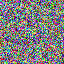
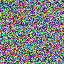
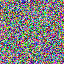
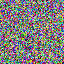

In [46]:
B, T, H, W, C = 4, 111, 64, 64, 3
frames = np.random.randint(0, 255, (B, T, H, W, C), dtype=np.uint8)

# Display GIF grid fully in-memory
display_rollouts_grid(frames, filetype="gif", width=250, height=250, ncols=4)

In [21]:
!pwd

/home/iz/workspace/vitascopic-nca


In [22]:
write_gif("/home/iz/a.gif", tensor[0])

GIF(str, height=500, sizing_mode='fixed', styles={'image-rendering': '...}, width=500)
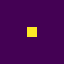

In [41]:
pn.pane.GIF(
    "./a.gif",
    width=500,
    height=500,
    styles={"image-rendering": "pixelated"},
)

In [ ]:
panes = [
    pn.pane.Video(
        f"a.mp4",
        width=256,
        loop=True,
        autoplay=True,
        muted=True,
        styles={
            "image-rendering": "pixelated",
            # "image-rendering": "crisp-edges",
            "video::-webkit-media-controls": "display: none",
        },
    )
    for i in range(1)
]
pn.Row(*panes)

Row
    [0] Video(str, autoplay=True, loop=True, muted=True, styles={'image-rendering': 'pixel...}, width=256)